# Convolutionnal autoencoder for image colorization

author: Alexandre Dauphin

In [40]:
import matplotlib
%matplotlib inline
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from matplotlib import pyplot as plt
from keras.datasets import cifar10
import tensorflow as tf
import keras
#Don't forget to choose the tensorflow backend

## 1. Convolutionnal autoencoder for color images

In [3]:
#Loading of the cifar10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255. #normalization
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # reshape for the CNN
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  #

In [ ]:
device="gpu"#use gpu or cpu
with tf.device("/" + device + ":0"):
    
    input_img = Input(shape=(32, 32, 3))  # Size of the input image
    
    #Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded=MaxPooling2D((2, 2), padding='same')(x)
    
    #the feature space is 4X4X16=256, thus smaller than the initial state 32X32X3=3072
    
    #decoder 
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    #we define the encoder and the autoencoder
    encoder = Model(input_img, encoded)
    autoencoder = Model(input_img, decoded)
    
    #in total, the autoencoder has 2,680,257 parameters
    
    #We choose ADAM for the optimizer and the mean square error for the loss function
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    #These three lines allow to save the best weights after each epochs ( if the weights are better)
    filepath="weights_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    
    #Training of the autoencoder
    autoencoder.fit(x_train, x_train,epochs=50,batch_size=200,shuffle=True,validation_data=(x_test, x_test),callbacks=callbacks_list)
    
    #to save the trained model
    autoencoder.save('my_colorizer_cifar.h5')
    encoder.save('my_encoderc_cifar.h5')
    #to save the history of the loss function
    val=autoencoder.history.history
    np.save('valc.npy',val)
    #if you want to load the data later on, use
    #autoencoder=keras.models.load_model(filepath+'my_autoencoder_cifar.h5')

In [4]:
#We then predict the reconstructed images by the autoencoder
encoded_imgs=encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

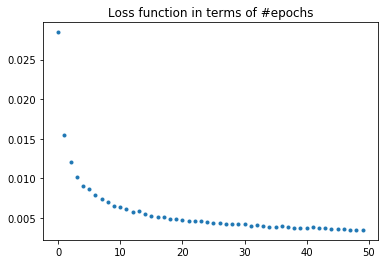

In [23]:
#Plot of the loss function in terms of the epochs
plt.plot(val.item().get('loss'),'.');
plt.title('Loss function in terms of #epochs');

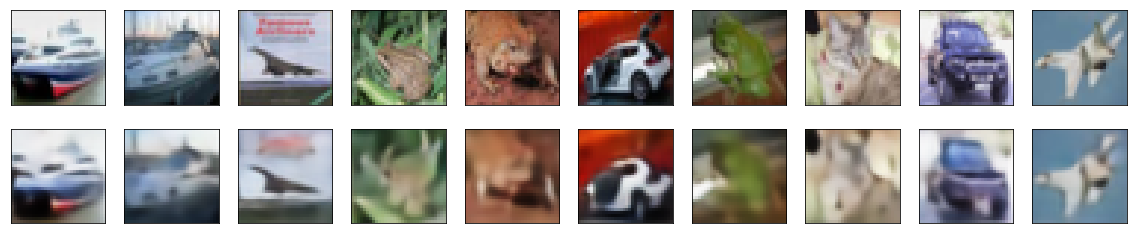

In [15]:
#Comparison with the initial images
n = 10
plt.figure(figsize=(20, 4))
for i in   range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Not too bad :-)

## 2. Convolutionnal autoencoder for colorizing images

We now construct a colorizer

In [33]:
#This function transforms the color images in gray images
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray.reshape(len(rgb),32,32,1)

In [41]:
#Loading of the cifar10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.#Normalization
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt he shape
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3)) 

#RGB to gray
x_traing=rgb2gray(x_train)
x_testg=rgb2gray(x_test)

In [ ]:
device="gpu" #if you cpu put cpu
with tf.device("/" + device + ":0"):
    
    input_img = Input(shape=(32, 32, 1))  
   
    x = Conv2D(3, (3, 3), activation='relu', padding='same')(input_img) #I added one layer to the previous autoencoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded=MaxPooling2D((2, 2), padding='same')(x)
    
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    adam=keras.optimizers.Adam(lr=1E-4)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    filepath="weights_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    
    #training of the colorizer. Now the inputs are in gray and the outputs are in color
    autoencoder.fit(x_traing, x_train,epochs=50,batch_size=200,shuffle=True,validation_data=(x_testg, x_test),callbacks=callbacks_list)
    
    autoencoder.save('my_colorizer_cifar.h5')
    encoder.save('my_encoderc_cifar.h5')
    val=autoencoder.history.history
    np.save('valc.npy',val)


In [ ]:
#We predict the decoded images on the test set
encoded_imgs=encoder.predict(x_testg)
decoded_imgs = autoencoder.predict(x_testg)

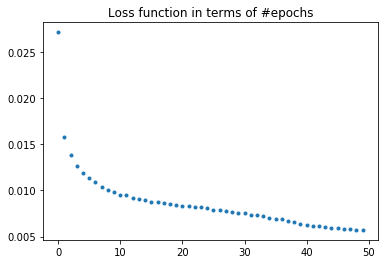

In [24]:
plt.plot(valc.item().get('loss'),'.');
plt.title('Loss function in terms of #epochs');

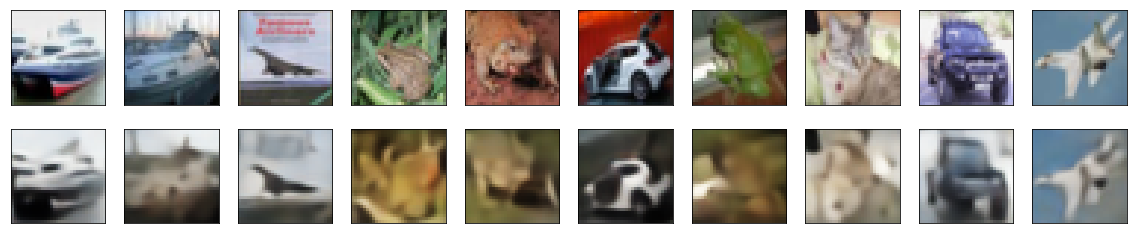

In [42]:
decoded_imgs=autoencoder.predict(x_testg[:20,:,:,:])
n = 10
plt.figure(figsize=(20, 4))
for i in   range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


The colorizer catches some of the colors but not all. It would be nice to try with a more complex CNN autoencoder